<a href="https://colab.research.google.com/github/Ovocode05/NeuroDeff/blob/main/relation2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
import os

In [2]:
class selfAdaptiveActivation(nn.Module):
  def __init__(self, activation_type="tanh"):
    super().__init__()
    self.activation_type = activation_type.lower()

    #learnable slope parameter
    self.alpha = nn.Parameter(torch.tensor(1.0))

    if self.activation_type not in ["tanh", "swish"]:
      raise ValueError(f"Unsupported activation type: {activation_type}")

  def forward(self, x):
    scaled_x = x* self.alpha
    if self.activation_type == "tanh":
      return torch.tanh(scaled_x)
    elif self.activation_type == "swish":
      return scaled_x * torch.sigmoid(scaled_x)

In [3]:
class SA_PINN(nn.Module):
  def __init__(self, layers, neurons, activation="tanh"):
    super(SA_PINN, self).__init__()

    self.activation_type = activation.lower()
    self.act_fn = selfAdaptiveActivation(self.activation_type)

    net_layers = [nn.Linear(1, neurons)]

    for _ in range(layers - 1):
      net_layers.append(nn.Linear(neurons, neurons))
      net_layers.append(selfAdaptiveActivation(self.activation_type))

    net_layers.append(nn.Linear(neurons, 2))  # Two outputs: T_f, T_s
    self.net = nn.Sequential(*net_layers)

  def forward(self, x):
        return self.net(x)

In [4]:
def gradients(T, x, order=1):
    if order == 1:
        grad = torch.autograd.grad(
            T, x,
            grad_outputs=torch.ones_like(T),
            create_graph=True,
            retain_graph=True,
            allow_unused=True  # Important for debugging
        )[0]
        if grad is None:
            raise RuntimeError("First derivative returned None. Check if x has requires_grad=True and is used.")
        return grad

    elif order == 2:
        T_x = gradients(T, x, order=1)
        if T_x is None:
            raise RuntimeError("First derivative for second-order grad is None.")
        grad2 = torch.autograd.grad(
            T_x, x,
            grad_outputs=torch.ones_like(T_x),
            create_graph=True,
            retain_graph=True,
            allow_unused=True,
            order=1
        )[0]
        if grad2 is None:
            raise RuntimeError("Second derivative returned None.")
        return grad2


In [5]:
def chebyshev_points(n):
    i = torch.arange(n).float()
    x = 0.5 * (1 - torch.cos((np.pi * i) / (n - 1)))
    return x.view(-1, 1)

In [6]:
def get_collocation_points(n_domain=300, n_bc=50):
    x_domain = chebyshev_points(n_domain) #more points near boundary area
    x_bc_left = torch.zeros(n_bc, 1)
    x_bc_right = torch.ones(n_bc, 1)

    x_domain.requires_grad_()
    x_bc_left.requires_grad_()
    x_bc_right.requires_grad_()

    return x_domain, x_bc_left, x_bc_right

In [7]:
def residual_loss(x_domain:torch.Tensor, model, config:dict):
  # Ensure x_domain requires gradients for differentiation
  x_domain.requires_grad_()
  output = model(x_domain)
  T_f = output[:, 0:1]
  T_s = output[:, 1:2]

  T_f_n = gradients(T_f, x_domain, order=1)
  T_f_nn = gradients(T_f_n, x_domain, order=1) # Calculate second derivative from the first derivative
  T_s_n = gradients(T_s, x_domain, order=1)
  T_s_nn = gradients(T_s_n, x_domain, order=1) # Calculate second derivative from the first derivative

  # Dynamic parameter handling
  def get_param(name):
        val = config["physics"][name]
        if name in config["physics"]["varying_params"]:
            if callable(val):
                return val(x_domain)
            elif isinstance(val, (list, np.ndarray)):
                return val
        return val

  eps = get_param('eps')
  k = get_param('k')
  delta = get_param('delta')
  beta = get_param('beta')
  Bi = get_param('Bi')

  eqn1 = (eps * k * (1 + delta * T_f) * T_f_nn +
            eps * k * delta * (T_f_n**2) +
            Bi * (T_s - T_f) - 1 - beta)

  eqn2 = ((1 - eps) * (1 + delta * T_s) * T_s_nn +
            (1 - eps) * delta * (T_s_n**2) -
            Bi * (T_s - T_f) + beta)

  loss_eqn = torch.mean(eqn1**2) + torch.mean(eqn2**2)
  return loss_eqn

In [8]:
def boundary_loss(model, x_left, x_right):
    # Ensure boundary points require gradients
    x_left.requires_grad_(True)
    x_right.requires_grad_(True)

    out_left = model(x_left)
    out_right = model(x_right)

    T_f_right = out_right[:, 0:1]
    T_s_right = out_right[:, 1:2]

    T_f_n_left = gradients(out_left[:, 0:1], x_left)
    T_s_n_left = gradients(out_left[:, 1:2], x_left)

    loss_bc = (
        torch.mean((T_f_right - 0)**2) +
        torch.mean((T_s_right - 0)**2) +
        torch.mean((T_f_n_left - 0)**2) +
        torch.mean((T_s_n_left - 0)**2)
    )
    return loss_bc

In [22]:
def relation_dict(x:np.ndarray) -> dict:

  bi_funcs = [
        lambda x: 50.0 * (1 - x), #0
        lambda x: 50.0 * (1 + x), #1
        lambda x: 50.0 * (1 - x**2), #2
        lambda x: 50.0 * (1 + x**2) #3
    ]

  RELATIONS = {
      "relation_2_a" : {
            "network": { "neurons":264, "layers":3},  # Same as before
            "training": {"lr":0.001,
                         "lose_weights": [1,110],
                         "epochs1":3000, "display_every":1000, "epochs2":6000 },
            "physics": {
                "eps": 0.1,
                "k": 25,
                "delta": -0.2,
                "beta": 10,
                "Bi": bi_funcs,
                "varying_params": ["Bi"]  # Specify which params vary
            },
      },
      "relation_2_b" : {
            "network": { "neurons":256, "layers":3},  # Same as before
            "training": { "lr":0.001,
                         "lose_weights": [1, 100],
                         "epochs1":3000, "display_every":1000, "epochs2":6000  },
            "physics": {
                "eps": 0.6,
                "k": 25,
                "delta": -0.2,
                "beta": 10,
                "Bi":bi_funcs,
                "varying_params": ["Bi"]  # Specify which params vary
            },
      }
  }
  return RELATIONS

In [10]:
class EarlyStopping:
    def __init__(self, patience=1000, min_delta=1e-6):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False

    def __call__(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


In [11]:
def resample_points_by_residual(model, config, total_domain=300, top_k=100):
    x_fine = chebyshev_points(total_domain)
    x_fine.requires_grad_()
    residual1 = residual_loss(x_fine, model, config).detach().cpu().numpy().flatten()
    residual2 = boundary_loss(model, x_fine[:50], x_fine[-50:]).detach().cpu().numpy().flatten()
    residuals = residual1 + residual2

    top_indices = np.argsort(residuals)[-top_k:]
    x_high_residual = x_fine[top_indices]
    x_random = x_fine[np.random.choice(len(x_fine), total_domain - top_k, replace=False)]

    x_new = torch.cat([x_high_residual, x_random], dim=0)
    x_new.requires_grad_()
    return x_new


In [24]:
def load_train_compiler(config, model, pre_trainied_path):
  #loading the weights
    if pre_trainied_path is not None:
      print(f"Loading pretrained weights from {pre_trainied_path}")
      model.load_state_dict(torch.load(pre_trainied_path))

    #setup optimizers and configs
    adam = torch.optim.Adam(model.parameters(), lr=config["training"]["lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam, 'min', factor=0.5, patience=200)
    w_pde, w_bc = config["training"]["lose_weights"]
    # early_stopper = EarlyStopping(patience=2000, min_delta=1e-5)

    x_domain, x_bc_left, x_bc_right = get_collocation_points()

    for epoch in range(config["training"]["epochs1"]):
      adam.zero_grad()

      loss_pde = residual_loss(x_domain, model, config)
      loss_bc = boundary_loss(model, x_bc_left, x_bc_right)
      loss = w_pde*loss_pde + w_bc*loss_bc

      loss.backward(retain_graph=True)
      adam.step()
      scheduler.step(loss)

      if epoch % config["training"]["display_every"] == 0 and epoch>0:
          print(f"Epoch {epoch}: Loss = {loss.item():.5e}  (PDE: {loss_pde.item():.2e}, BC: {loss_bc.item():.2e})")
          x_domain = resample_points_by_residual(model, config)

    print("Starting L-BFGS refinement...")
    lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=100)

    def closure():
          lbfgs.zero_grad()
          loss_pde = residual_loss(x_domain, model, config)
          loss_bc = boundary_loss(model, x_bc_left, x_bc_right)
          loss = w_pde * loss_pde + w_bc * loss_bc
          loss.backward(retain_graph=True)
          return loss

    lbfgs.step(closure)

    print("L-BFGS refinement complete.")

    print("Starting Adam refinement...")
    early_stopper2 = EarlyStopping(patience=4000, min_delta=1e-5)
    adam2 = torch.optim.AdamW(model.parameters(), lr=config["training"]["lr"])
    scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(adam2, 'min', factor=0.5, patience=200)

    for epoch in range(config["training"]["epochs2"]):
      adam2.zero_grad()
      loss_pde2 = residual_loss(x_domain, model, config)
      loss_bc2 = boundary_loss(model, x_bc_left, x_bc_right)
      loss2 = w_pde * loss_pde2 + w_bc * loss_bc2

      loss2.backward(retain_graph=True)
      adam2.step()
      scheduler2.step(loss2)

      if epoch % config["training"]["display_every"] == 0 and epoch>0:
          print(f"Epoch {epoch}: Loss = {loss2.item():.5e}  (PDE: {loss_pde2.item():.2e}, BC: {loss_bc2.item():.2e})")

      early_stopper2(loss2.item())
      if early_stopper2.should_stop:
              print(f"Early stopping at epoch {epoch}")
              break

    print("Adamw completed")

In [20]:
def train_pinn(config:dict, pre_trainied_path:str = None):
  #create the model
  for i in range(4):
    if i % 2 == 0:
      model = SA_PINN(config["network"]["layers"], config["network"]["neurons"], activation="tanh")
      load_train_compiler(config,model, pre_trainied_path)
    else:
      model = SA_PINN(config["network"]["layers"], config["network"]["neurons"], activation="swish")
      load_train_compiler(config, model, pre_trainied_path)

    return model

In [14]:
def predict_temperatures(model, x_test)->dict:
  model.eval()
  with torch.no_grad():
    T_pred = model(x_test)
  return T_pred

In [26]:
def run_relation(relation:str, n: np.ndarray) -> dict:
    config = relation_dict(n)[relation]
    results_predict = {}

    # Prepare combinations of varying parameters
    varying_params = config["physics"]["varying_params"]
    param_values = [
        config["physics"][p] if isinstance(config["physics"][p], (list, np.ndarray)) else [config["physics"][p]]
        for p in varying_params
    ]

    for i, combo in enumerate(product(*param_values)):
        # Create identifier for this combination
        param_str = "_".join(f"{p}={v}" for p, v in zip(varying_params, combo))
        print(f"\n🔁 Training {relation} with {param_str}")

        # Make a fresh copy of the physics config
        current_physics = {**config["physics"]}

        for p, v in zip(varying_params, combo):
            current_physics[p] = v

        current_config = {
            "network": config["network"],
            "training": config["training"],
            "physics": current_physics
        }

        # Train the PINN

        # Save model for potential transfer learning
        if i % 2 == 0:
            model = train_pinn(current_config)
            torch.save(model.state_dict(), f'base_bi_model{i}.pth')
            print("Base model saved for transfer learning.")
        else:
            path = f'base_bi_model{i-1}.pth'
            model = train_pinn(current_config, pre_trainied_path=path)
            os.remove(path)

        # Predict temperature profiles
        T_pred = predict_temperatures(model, n)
        results_predict[param_str] = {
            "x": torch.flatten(n),
            "T_f": T_pred[:, 0:1],
            "T_s": T_pred[:, 1:2],
            "params": dict(zip(varying_params, combo))
        }

    return results_predict


In [16]:
from collections import defaultdict
def plot_grouped_by_Bi(results, title_prefix="PINN Prediction Grouped by Bi"):
    """
    For each unique Bi (from result key), plot all (Tf, Ts) curves for that Bi in one figure.
    """
    grouped = defaultdict(dict)
    for key, res in results.items():
        # Parse key like "Bi=<func>_delta=0.4"
        bi_key = [kv for kv in key.split('_') if kv.startswith("Bi=")][0]
        grouped[bi_key][key] = res

    # Step 2: Plot each Bi group in its own figure
    for bi_label, group in grouped.items():
        plt.figure(figsize=(10, 6))
        colors = plt.cm.tab10.colors

        for i, (label, res) in enumerate(group.items()):
            x = res["x"]
            T_f = res["T_f"].flatten()
            T_s = res["T_s"].flatten()
            color = colors[i % len(colors)]

            plt.plot(x, T_s, color=color, linestyle='-')
            plt.plot(x, T_f, color=color, linestyle='--')

        plt.xlabel("x")
        plt.ylabel("Temperature")
        plt.title(f"{title_prefix}: {bi_label}")
        plt.legend(fontsize="small")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



🔁 Training relation_2_a with Bi=<function relation_dict.<locals>.<lambda> at 0x78ff7ebd9260>
Epoch 1000: Loss = 3.24996e-03  (PDE: 3.25e-03, BC: 3.14e-08)
Epoch 2000: Loss = 3.44540e-03  (PDE: 3.44e-03, BC: 4.28e-08)
Starting L-BFGS refinement...
L-BFGS refinement complete.
Starting Adam refinement...
Epoch 1000: Loss = 1.60778e-02  (PDE: 1.58e-02, BC: 2.25e-06)
Epoch 2000: Loss = 1.47857e-02  (PDE: 1.46e-02, BC: 1.88e-06)
Epoch 3000: Loss = 1.47314e-02  (PDE: 1.45e-02, BC: 1.88e-06)
Epoch 4000: Loss = 1.47307e-02  (PDE: 1.45e-02, BC: 1.89e-06)
Early stopping at epoch 4000
Adamw completed
Base model saved for transfer learning.

🔁 Training relation_2_a with Bi=<function relation_dict.<locals>.<lambda> at 0x7900781d9bc0>
Loading pretrained weights from base_bi_model0.pth
Epoch 1000: Loss = 3.69436e-01  (PDE: 5.45e-02, BC: 2.86e-03)
Epoch 2000: Loss = 2.57796e-01  (PDE: 4.34e-02, BC: 1.95e-03)
Starting L-BFGS refinement...
L-BFGS refinement complete.
Starting Adam refinement...
Epoch 10

/tmp/ipython-input-16-373405371.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


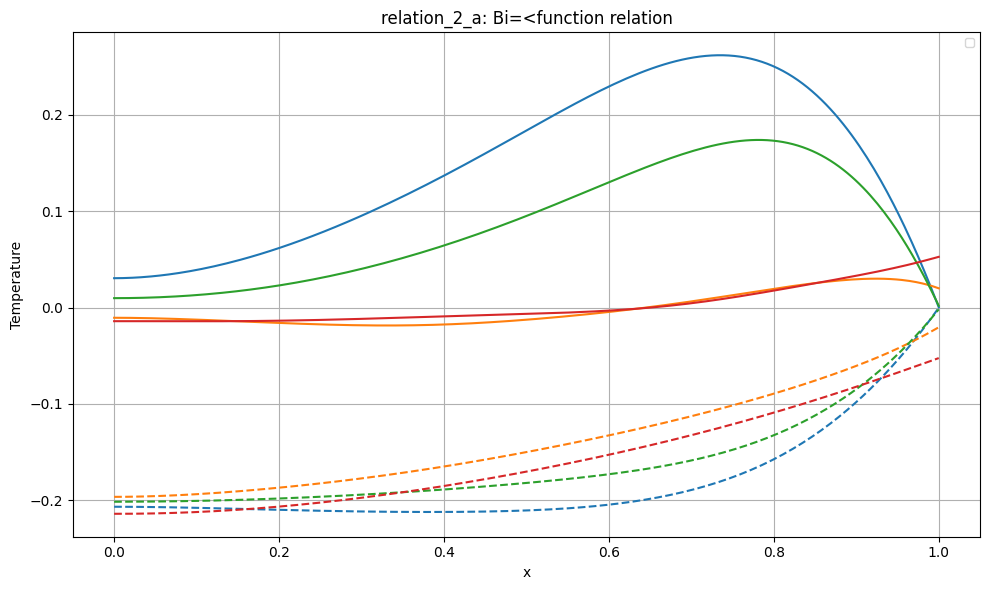


🔁 Training relation_2_b with Bi=<function relation_dict.<locals>.<lambda> at 0x7900781ede40>
Epoch 1000: Loss = 1.74057e-02  (PDE: 1.73e-02, BC: 5.60e-07)
Epoch 2000: Loss = 1.08546e-02  (PDE: 1.08e-02, BC: 4.33e-07)
Starting L-BFGS refinement...
L-BFGS refinement complete.
Starting Adam refinement...
Epoch 1000: Loss = 1.36801e-02  (PDE: 1.36e-02, BC: 1.16e-06)
Epoch 2000: Loss = 1.33915e-02  (PDE: 1.33e-02, BC: 1.18e-06)
Epoch 3000: Loss = 1.33792e-02  (PDE: 1.33e-02, BC: 1.20e-06)
Epoch 4000: Loss = 1.33790e-02  (PDE: 1.33e-02, BC: 1.20e-06)
Early stopping at epoch 4000
Adamw completed
Base model saved for transfer learning.

🔁 Training relation_2_b with Bi=<function relation_dict.<locals>.<lambda> at 0x7900781da7a0>
Loading pretrained weights from base_bi_model0.pth
Epoch 1000: Loss = 4.61238e-01  (PDE: 1.79e-01, BC: 2.82e-03)
Epoch 2000: Loss = 3.62639e-01  (PDE: 1.13e-01, BC: 2.50e-03)
Starting L-BFGS refinement...
L-BFGS refinement complete.
Starting Adam refinement...
Epoch 10

/tmp/ipython-input-16-373405371.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="small")


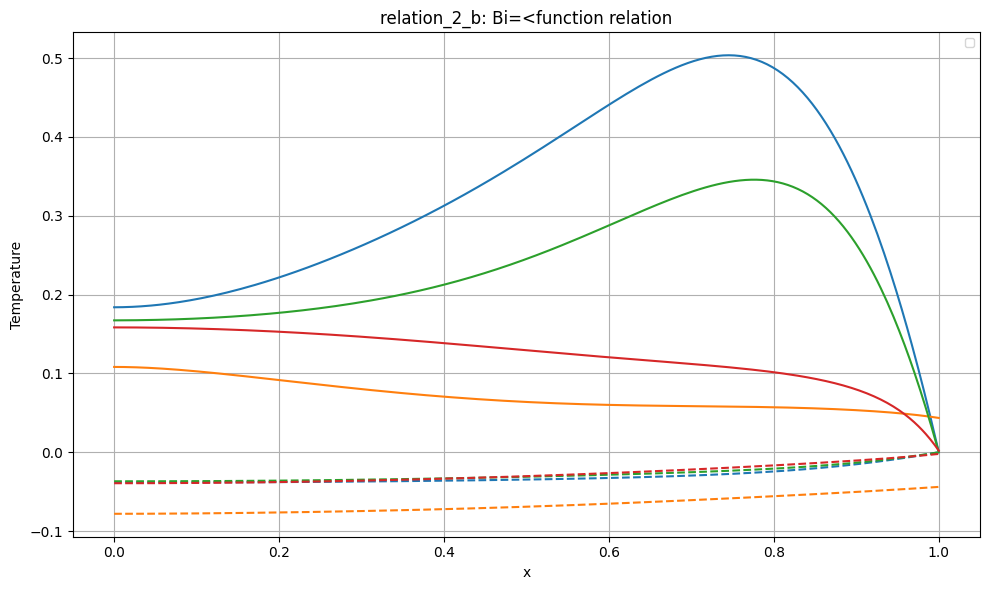

In [27]:
all_results = {}
n = chebyshev_points(200)

for relation in ["relation_2_a", "relation_2_b"]:
    all_results[relation] = run_relation(relation, n)
    plot_grouped_by_Bi(all_results[relation], title_prefix=relation)